# ML with TF-IDF + Logistic Regression on IMDB Dataset

In this notebook, we will:

0. Set a NumPy random seed and load the **IMDB** dataset from Hugging Face, sampling 8k examples for training and 3k for testing. We will further split the training set into **train** and **dev**.
1. Tackle sentiment classification with **TF-IDF** features and **Logistic Regression**.
2. Explore key hyperparameters: `stop_words`, `tokenizer`, `analyzer`, `min_df`, `max_df`, `ngram_range`, `max_features`, and `vocabulary` with clear examples.
3. Create a scikit-learn **Pipeline** with a pre-processing class (if needed), TF-IDF vectorizer, and Logistic Regression (with comments on regularization parameters and class weights).
4. Evaluate the results on the **dev** and **test** sets.
5. Analyze feature importance:
    - a. Look at the contribution of each token.
    - b. Show (with color highlights) which words drive the predictions.
    - c. Rank the top words for positive and negative classes.
6. Update the pre-processing pipelines based on this analysis.

## 0. Load the IMDB dataset

### What is the IMDB Dataset?

The IMDB dataset is a widely-used benchmark in sentiment analysis. It consists of movie reviews collected from the Internet Movie Database (IMDB), each labeled with a binary sentiment indicating whether the review is **positive** or **negative**.

#### Key Features:
- **Text Reviews:** Each record is a movie review written in natural language.
- **Binary Sentiment Labels:** Reviews are marked as `0` (negative) or `1` (positive).
- **Benchmark Dataset:** It is extensively used for training and evaluating models in natural language processing, particularly for sentiment classification tasks.

I set a random seed for reproducibility. I sample 8000 examples for training and 3000 for testing. I further split the training set into train and dev (80/20 split).

In [1]:
# 0. Setup & Data Loading
import numpy as np
import pandas as pd
from datasets import load_dataset
from sklearn.model_selection import train_test_split

# Set numpy random seed for reproducibility
np.random.seed(42)

# Load the IMDB dataset from Hugging Face
imdb = load_dataset("imdb")

# Sample 8000 examples for training from the original train split
imdb_train_full = imdb["train"]
imdb_test_full = imdb["test"]

train_df = pd.DataFrame(imdb_train_full)
test_df = pd.DataFrame(imdb_test_full)

# Sample 8000 from train and 3000 from test
train_df = train_df.sample(n=8000, random_state=42).reset_index(drop=True)
test_df = test_df.sample(n=3000, random_state=42).reset_index(drop=True)

# Split train_df into train and dev (e.g., 80/20 split)
train_df, dev_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df["label"])

print("Train size:", len(train_df))
print("Dev size:", len(dev_df))
print("Test size:", len(test_df))

README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Train size: 6400
Dev size: 1600
Test size: 3000


## 1. TF-IDF + Logistic Regression for Sentiment Classification

We will build a machine learning model using TF-IDF features combined with Logistic Regression to predict sentiment (positive/negative) from IMDB reviews.

As mentioned in the slides, we can use the `TfidfVectorizer` to convert the text data into a matrix of TF-IDF features.

We can then use a `LogisticRegression` model to predict the sentiment of the reviews. It's a simple model that is easy to understand and interpret.

We can also use a `Pipeline` to streamline the process of converting the text data into TF-IDF features and then using the Logistic Regression model to predict the sentiment. `Pipeline` is a powerful tool that allows us to chain together multiple steps of the process into a single object.

In [18]:
# Import necessary libraries for TF-IDF and Logistic Regression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import FunctionTransformer

# For demonstration, we define a very simple text preprocessor (could be extended)
import re

def simple_preprocessor(text):
    # Lowercase and remove non-alphabetic characters
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    return text

# Example hyperparameter settings for TfidfVectorizer
tfidf_params = {
    "stop_words": "english",           # Remove English stop words
    "tokenizer": None,                   # Use default tokenizer; can be replaced by a custom one
    "analyzer": "word",                # Analyze words (as opposed to characters)
    "min_df": 5,                         # Ignore terms that appear in fewer than 5 documents
    "max_df": 0.8,                       # Ignore terms that appear in more than 80% of the documents
    "ngram_range": (1, 1),               # Unigrams by default (can change to (1,2) for bigrams, etc.)
    "max_features": 10000                # Limit vocabulary size
}

# Create the pipeline
pipeline = Pipeline([
    ("preprocessor", FunctionTransformer(lambda X: [simple_preprocessor(text) for text in X])),
    ("tfidf", TfidfVectorizer(**tfidf_params)),
    ("logreg", LogisticRegression(
         # See https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
         # Regularization: C is the inverse of regularization strength (smaller values specify stronger regularization)
         # class_weight: can be set to 'balanced' to automatically adjust weights inversely proportional to class frequencies
         C=1.0,
         penalty='l2',
         solver='lbfgs',
         max_iter=1000,
         class_weight='balanced'
     ))
])

# Display the pipeline steps
pipeline

Pipeline(steps=[('preprocessor',
                 FunctionTransformer(func=<function <lambda> at 0x16c003b00>)),
                ('tfidf',
                 TfidfVectorizer(max_df=0.8, max_features=10000, min_df=5,
                                 stop_words='english')),
                ('logreg',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

## 2. Hyperparameter Examples for TF-IDF

Below are some key parameters for the TF-IDF vectorizer with brief explanations:

- **stop_words**: Words to remove (e.g., "english" removes common English stop words).
- **tokenizer**: Function to split text into tokens. You can provide your own function.
- **analyzer**: Determines whether the analyzer operates on word or character level.
- **min_df**: Minimum document frequency; ignore terms that appear in fewer documents.
- **max_df**: Maximum document frequency; ignore terms that appear in a large proportion of documents.
- **ngram_range**: The range of n-values for different n-grams to be extracted (e.g., (1,2) for unigrams and bigrams).
- **max_features**: Maximum number of features (vocabulary size) to consider.
- **vocabulary**: Optionally, you can pass a custom vocabulary.

Below are examples of how those parameters affect the feature matrix.

### Stop_words
**Description:** Removes common words from the text.  
**Example:** Remove common English stop words.

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Using built-in stop words for English
vectorizer1 = TfidfVectorizer(stop_words="english")
vectorizer2 = TfidfVectorizer(stop_words=None)

documents = ["This is a sample document.", "Another document with more text."]

tfidf_matrix1 = vectorizer1.fit_transform(documents)
tfidf_matrix2 = vectorizer2.fit_transform(documents)

print("Features with stop_words='english':", vectorizer1.get_feature_names_out())
print("Features without stop_words:", vectorizer2.get_feature_names_out())

Features with stop_words='english': ['document' 'sample' 'text']
Features without stop_words: ['another' 'document' 'is' 'more' 'sample' 'text' 'this' 'with']


### Tokenizer
**Description:** Function to split text into tokens.  
**Example:** Use a custom tokenizer.

You'll see a warning when you use a custom tokenizer as you won't be using the default `token_pattern` anymore.

In [17]:
def custom_tokenizer(text):
    # Remove punctuation and split by whitespace
    text = re.sub(r'[^\w\s]', '', text)
    return text.lower().split()

vectorizer1 = TfidfVectorizer(tokenizer=custom_tokenizer)
vectorizer2 = TfidfVectorizer(tokenizer=None)

documents = ["Hello, world! This is an example. I'm happy to see you.", "Custom tokenizer works well."]

tfidf_matrix1 = vectorizer1.fit_transform(documents)
tfidf_matrix2 = vectorizer2.fit_transform(documents)

print("Tokens using custom tokenizer:", vectorizer1.get_feature_names_out())
print("Tokens without custom tokenizer:", vectorizer2.get_feature_names_out())

Tokens using custom tokenizer: ['an' 'custom' 'example' 'happy' 'hello' 'im' 'is' 'see' 'this' 'to'
 'tokenizer' 'well' 'works' 'world' 'you']
Tokens without custom tokenizer: ['an' 'custom' 'example' 'happy' 'hello' 'is' 'see' 'this' 'to'
 'tokenizer' 'well' 'works' 'world' 'you']


/Users/agomberto/Library/Caches/pypoetry/virtualenvs/bse-nlp-DetGwK6_-py3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


### Analyzer
**Description:** Determines whether the analyzer operates on word or character level.  
**Example:** Analyze words, characters or character-word boundary.

‘char_wb’ creates character n-grams only from text inside word boundaries.

In [9]:
# Use character analyzer (each character n-gram will be a feature)
vectorizer1 = TfidfVectorizer(analyzer="char", ngram_range=(2, 4))
vectorizer2 = TfidfVectorizer(analyzer="word", ngram_range=(2, 4))
vectorizer3 = TfidfVectorizer(analyzer="char_wb", ngram_range=(2, 4))

documents = ["This is a sample document.", "Another document with more text."]

tfidf_matrix1 = vectorizer1.fit_transform(documents)
tfidf_matrix2 = vectorizer2.fit_transform(documents)
tfidf_matrix3 = vectorizer3.fit_transform(documents)

print("Character n-grams as features:", vectorizer1.get_feature_names_out())
print("Character-word boundary n-grams as features:", vectorizer3.get_feature_names_out())
print("Word n-grams as features:", vectorizer2.get_feature_names_out())


Character n-grams as features: [' a' ' a ' ' a s' ' d' ' do' ' doc' ' i' ' is' ' is ' ' m' ' mo' ' mor'
 ' s' ' sa' ' sam' ' t' ' te' ' tex' ' w' ' wi' ' wit' 'a ' 'a s' 'a sa'
 'am' 'amp' 'ampl' 'an' 'ano' 'anot' 'cu' 'cum' 'cume' 'do' 'doc' 'docu'
 'e ' 'e d' 'e do' 'e t' 'e te' 'en' 'ent' 'ent ' 'ent.' 'er' 'er ' 'er d'
 'ex' 'ext' 'ext.' 'h ' 'h m' 'h mo' 'he' 'her' 'her ' 'hi' 'his' 'his '
 'is' 'is ' 'is a' 'is i' 'it' 'ith' 'ith ' 'le' 'le ' 'le d' 'me' 'men'
 'ment' 'mo' 'mor' 'more' 'mp' 'mpl' 'mple' 'no' 'not' 'noth' 'nt' 'nt '
 'nt w' 'nt.' 'oc' 'ocu' 'ocum' 'or' 'ore' 'ore ' 'ot' 'oth' 'othe' 'pl'
 'ple' 'ple ' 'r ' 'r d' 'r do' 're' 're ' 're t' 's ' 's a' 's a ' 's i'
 's is' 'sa' 'sam' 'samp' 't ' 't w' 't wi' 't.' 'te' 'tex' 'text' 'th'
 'th ' 'th m' 'the' 'ther' 'thi' 'this' 'um' 'ume' 'umen' 'wi' 'wit'
 'with' 'xt' 'xt.']
Character-word boundary n-grams as features: [' a' ' a ' ' an' ' ano' ' d' ' do' ' doc' ' i' ' is' ' is ' ' m' ' mo'
 ' mor' ' s' ' sa' ' sam' ' t' 

### Min_df and Max_df
**Description:** Minimum and maximum document frequencies for terms to be included in the vocabulary.  
**Example:** Include terms that appear in at least 5 documents and at most 80% of the documents.

In the following example, we see that the features map is changing when we change the `min_df` and `max_df` parameters.

In [10]:
vectorizer0 = TfidfVectorizer()
vectorizer1 = TfidfVectorizer(min_df=2)
vectorizer2 = TfidfVectorizer(max_df=0.8)

documents = ["This is a sample document.", "Another document with more text.", "This is another document."]


tfidf_matrix0 = vectorizer0.fit_transform(documents)
tfidf_matrix1 = vectorizer1.fit_transform(documents)
tfidf_matrix2 = vectorizer2.fit_transform(documents)

print("Features without min_df and max_df:", vectorizer0.get_feature_names_out())
print("Features with min_df=2:", vectorizer1.get_feature_names_out())
print("Features with max_df=0.8:", vectorizer2.get_feature_names_out())

Features without min_df and max_df: ['another' 'document' 'is' 'more' 'sample' 'text' 'this' 'with']
Features with min_df=2: ['another' 'document' 'is' 'this']
Features with max_df=0.8: ['another' 'is' 'more' 'sample' 'text' 'this' 'with']


### N-gram Range
**Description:** The range of n-values for different n-grams to be extracted (e.g., (1,2) for unigrams and bigrams).  
**Example:** Extract unigrams and bigrams.

In [11]:
vectorizer1 = TfidfVectorizer(ngram_range=(1, 2))
vectorizer2 = TfidfVectorizer(ngram_range=(1, 3))

documents = ["this is a test", "another test example"]

tfidf_matrix1 = vectorizer1.fit_transform(documents)
tfidf_matrix2 = vectorizer2.fit_transform(documents)

print("Features with ngram_range=(1,2):", vectorizer1.get_feature_names_out())
print("Features with ngram_range=(1,3):", vectorizer2.get_feature_names_out())

Features with ngram_range=(1,2): ['another' 'another test' 'example' 'is' 'is test' 'test' 'test example'
 'this' 'this is']
Features with ngram_range=(1,3): ['another' 'another test' 'another test example' 'example' 'is' 'is test'
 'test' 'test example' 'this' 'this is' 'this is test']


### Max_features
**Description:** Maximum number of features (vocabulary size) to consider.  
**Example:** Limit the vocabulary size to 2.

Only consider the top `max_features` ordered by term frequency across the corpus.


In [12]:
vectorizer = TfidfVectorizer(max_features=3)
documents = ["This is a document with a lot of words", "This is another document with a lot of words"]
tfidf_matrix = vectorizer.fit_transform(documents)
print("Features with max_features=3:", vectorizer.get_feature_names_out())

Features with max_features=3: ['document' 'is' 'lot']


### Vocabulary
**Description:** Optionally, you can pass a custom vocabulary.  
**Example:** Use a custom vocabulary.

The feature map will be the intersection of the vocabulary and the features in the corpus.

In [15]:
custom_vocab1 = {"data": 0, "science": 1, "machine": 2, "learning": 3}
custom_vocab2 = {"data": 0, "science": 1, "machine": 2, "is": 3, "amazing": 4}

vectorizer1 = TfidfVectorizer(vocabulary=custom_vocab1)
vectorizer2 = TfidfVectorizer(vocabulary=custom_vocab2)

documents = ["data science is amazing", "machine learning is part of data science"]

tfidf_matrix1 = vectorizer1.fit_transform(documents)
tfidf_matrix2 = vectorizer2.fit_transform(documents)

print("Features using custom vocabulary:", vectorizer1.get_feature_names_out())
print("Features using custom vocabulary:", vectorizer2.get_feature_names_out())

Features using custom vocabulary: ['data' 'science' 'machine' 'learning']
Features using custom vocabulary: ['data' 'science' 'machine' 'is' 'amazing']


## 3. Train the Model and Evaluate

We now train our pipeline on the training set, evaluate on the dev set, and finally check performance on the test set.

You'll see below that this is straightforward as we just need to call the `fit` method on the training set and then the `predict` method on the dev and test sets.

In [19]:
# Train the model
pipeline.fit(train_df["text"], train_df["label"])

# Evaluate on dev set
dev_preds = pipeline.predict(dev_df["text"])
dev_accuracy = accuracy_score(dev_df["label"], dev_preds)
dev_precision = precision_score(dev_df["label"], dev_preds)
dev_recall = recall_score(dev_df["label"], dev_preds)
dev_f1 = f1_score(dev_df["label"], dev_preds)

print("Dev Set Metrics:")
print(f"Accuracy: {dev_accuracy*100:.2f}%")
print(f"Precision: {dev_precision*100:.2f}%")
print(f"Recall: {dev_recall*100:.2f}%")
print(f"F1-score: {dev_f1*100:.2f}%")

# Evaluate on test set
test_preds = pipeline.predict(test_df["text"])
test_accuracy = accuracy_score(test_df["label"], test_preds)
test_precision = precision_score(test_df["label"], test_preds)
test_recall = recall_score(test_df["label"], test_preds)
test_f1 = f1_score(test_df["label"], test_preds)

print("\nTest Set Metrics:")
print(f"Accuracy: {test_accuracy*100:.2f}%")
print(f"Precision: {test_precision*100:.2f}%")
print(f"Recall: {test_recall*100:.2f}%")
print(f"F1-score: {test_f1*100:.2f}%")

Dev Set Metrics:
Accuracy: 85.31%
Precision: 84.16%
Recall: 87.00%
F1-score: 85.56%

Test Set Metrics:
Accuracy: 85.23%
Precision: 83.31%
Recall: 86.71%
F1-score: 84.98%


Results are quite good if we compare to the random baseline (50% F1). We outperform the baseline by a large margin. We also see that the results of precision and recall are quite good around 85% without a clear decrepancy between the two.

Let's look at the feature importance analysis to understand which tokens drive the predictions and maybe find some interesting patterns that will help us improve the pipeline.

## 4. Feature Importance Analysis

After training, we analyze the learned logistic regression coefficients to understand which tokens drive the predictions.

a. **Contribution of Each Token**: We extract the coefficient for each feature (token).
b. **Visual Examples**: We'll highlight tokens in some example reviews (this example uses HTML formatting for color).
c. **Ranking Top Tokens**: We rank tokens for each class (positive and negative).

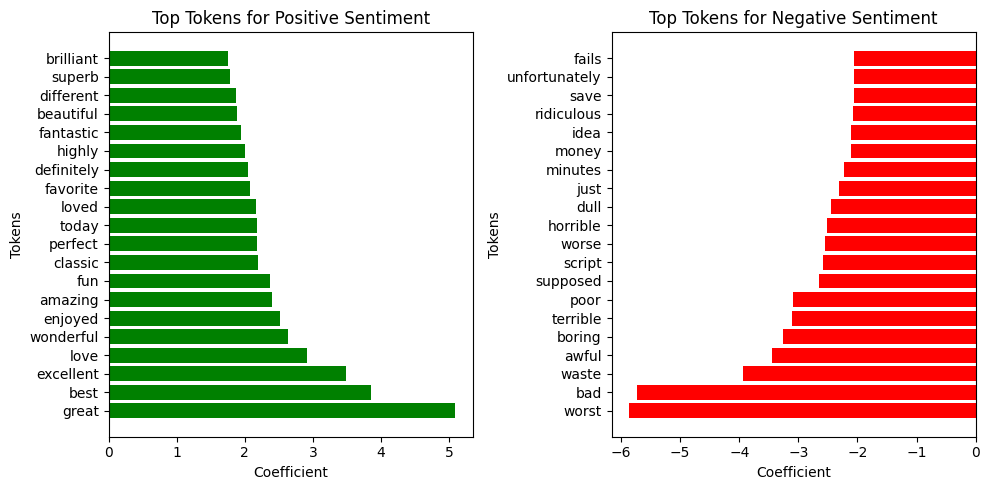

In [29]:
from IPython.display import display, HTML
from matplotlib import pyplot as plt
import pandas as pd

# Get the trained Logistic Regression model from the pipeline
logreg = pipeline.named_steps['logreg']
tfidf = pipeline.named_steps['tfidf']

# Get feature names (tokens)
feature_names = np.array(tfidf.get_feature_names_out())

# Logistic Regression coefficients
coefficients = logreg.coef_[0]

# a. Contribution of each token
# Create a DataFrame to display tokens and their coefficients
coef_df = pd.DataFrame({
    'token': feature_names,
    'coefficient': coefficients
})

# b. Top tokens for positive (assumed label 1) and negative (assumed label 0) sentiment
top_positive = coef_df.sort_values(by='coefficient', ascending=False).head(20)
top_negative = coef_df.sort_values(by='coefficient').head(20)

#Make an horizontal plot of the top tokens for positive and negative sentiment
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ax[0].barh(top_positive['token'], top_positive['coefficient'], color='green')
ax[1].barh(top_negative['token'], top_negative['coefficient'], color='red')
ax[0].set_xlabel('Coefficient')
ax[0].set_ylabel('Tokens')
ax[0].set_title('Top Tokens for Positive Sentiment')
ax[1].set_xlabel('Coefficient')
ax[1].set_ylabel('Tokens')
ax[1].set_title('Top Tokens for Negative Sentiment')

plt.tight_layout()
plt.show()


We see interesting patterns here. For positive label, the top tokens are mostly related to sentiment. Words like "great", "wonderful", "excellent", "fantastic" are all positive words. For negative label, the top tokens are mostly related to sentiment. Words like "bad", "terrible", "horrible", "awful" are all negative words.

Nevertheless, we see some tokens that are not related to sentiment but are still important for the classification. For example, "today" or "script" are important for the classification but they are not related to sentiment. It looks like the model overfits on those tokens because they may be present too many times in the corpus for positive or negative reviews.

Let's check that hypothesis by looking at the probability to have a positive or negative review depending on the presence of a token.


In [37]:
# Get the TF-IDF vectorizer from the pipeline
tfidf = pipeline.named_steps['tfidf']

# Get the vocabulary and feature names
vocabulary = tfidf.vocabulary_
feature_names = tfidf.get_feature_names_out()

# We just want to know if a word appears or not
# Transform the training data
X_count = tfidf.transform(train_df["text"])

# Convert to binary (1 if word appears, 0 if not)
X_binary = (X_count > 0).astype(int)

# Get the labels
y = train_df["label"].values

# Calculate probabilities
word_sentiment_probs = {}

# Total counts for each sentiment
positive_count = np.sum(y == 1)
negative_count = np.sum(y == 0)
total_count = len(y)

# For each word in the vocabulary
for i, word in enumerate(feature_names):
    # Get documents containing this word
    docs_with_word = X_binary[:, i].toarray().flatten()
    
    # Count documents with this word for each sentiment
    positive_with_word = np.sum(docs_with_word & (y == 1))
    negative_with_word = np.sum(docs_with_word & (y == 0))
    total_with_word = np.sum(docs_with_word)
    
    if total_with_word > 0:  # Avoid division by zero
        # P(positive | word)
        p_positive_given_word = positive_with_word / total_with_word
        
        # P(negative | word)
        p_negative_given_word = negative_with_word / total_with_word
        
        # Store the probabilities
        word_sentiment_probs[word] = {
            'P(positive|word)': p_positive_given_word,
            'P(negative|word)': p_negative_given_word,
            'count': total_with_word,
            'positive_count': positive_with_word,
            'negative_count': negative_with_word
        }

# Convert to DataFrame for easier analysis
probs_df = pd.DataFrame.from_dict(word_sentiment_probs, orient='index')

# Sort by probability of positive sentiment
most_positive_words = probs_df.sort_values(by='P(positive|word)', ascending=False).head(20)
most_negative_words = probs_df.sort_values(by='P(negative|word)', ascending=False).head(20)

# Display results
print("Words most associated with positive sentiment:")
print(most_positive_words[['P(positive|word)', 'count']])

print("\nWords most associated with negative sentiment:")
print(most_negative_words[['P(negative|word)', 'count']])

Words most associated with positive sentiment:
             P(positive|word)  count
katey                     1.0      5
kline                     1.0     12
haines                    1.0      7
bittersweet               1.0     10
curr                      1.0      5
knockout                  1.0      8
tate                      1.0      5
adele                     1.0      5
askey                     1.0      6
johansson                 1.0      9
christina                 1.0      8
krell                     1.0      6
waterman                  1.0      5
fido                      1.0      5
jonestown                 1.0      6
joss                      1.0      8
harilal                   1.0      5
rotoscoped                1.0      6
bjm                       1.0      5
daisies                   1.0      5

Words most associated with negative sentiment:
             P(negative|word)  count
reb                       1.0      5
mercifully                1.0      8
uwe              

In [38]:
word_sentiment_probs["today"]

{'P(positive|word)': np.float64(0.7734375),
 'P(negative|word)': np.float64(0.2265625),
 'count': np.int64(256),
 'positive_count': np.int64(198),
 'negative_count': np.int64(58)}

In [49]:
word_sentiment_probs["movie"]

{'P(positive|word)': np.float64(0.4669042769857434),
 'P(negative|word)': np.float64(0.5330957230142567),
 'count': np.int64(3928),
 'positive_count': np.int64(1834),
 'negative_count': np.int64(2094)}

In [48]:
word_sentiment_probs["film"]

{'P(positive|word)': np.float64(0.49778024417314093),
 'P(negative|word)': np.float64(0.5022197558268591),
 'count': np.int64(3604),
 'positive_count': np.int64(1794),
 'negative_count': np.int64(1810)}

Here we see a lot of words that may not be related to sentiment but are still important for the classification. For example, "tate" or "joss". And we look at the exemple of "today" that we saw before, the probability to have a positive or negative review depending on the presence of "today" is clearly skewed towards positive reviews. There may be a reason, but this word without context, is not a good feature for the classification. Therefore maybe we should remove those words from the vocabulary or use them only with more context ie with higher ngrams.

Let's see another way of looking at the feature importance by highlighting the words in some example reviews.

In [42]:
# c. Example: Highlight words in a review (for illustration, using HTML styling)
# Let's put intensity of the color to the coefficient of the token
# For instance, if the coefficient is high, the color should be more intense
def highlight_review(review, threshold=0.5):
    tokens = review.split()
    highlighted = []
    for token in tokens:
        token_clean = token.lower()
        if token_clean in feature_names:
            # Find index of token in the vocabulary
            idx = np.where(feature_names == token_clean)[0][0]
            coef = coefficients[idx]
            # Color positive words in green and negative in red
            if coef > threshold:
                token = f'<span style="color:green">{token}</span>'
            elif coef < -threshold:
                token = f'<span style="color:red">{token}</span>'
        highlighted.append(token)
    return ' '.join(highlighted)

# Show highlighted review example (use IPython.display to render HTML)
from IPython.display import display, HTML


for i in range(10):
    sample_review = test_df['text'].iloc[i]
    display(HTML(highlight_review(sample_review, threshold=0.1)))
    print('--------------------------------')

--------------------------------


--------------------------------


--------------------------------


--------------------------------


--------------------------------


--------------------------------


--------------------------------


--------------------------------


--------------------------------


--------------------------------


This is quit interesting to see the results as  we see words like "American", "think" or "right" which are highlighted in red and words like "maybe", "tell" or "film", that are highlighted in green. WE see also a lot of names.

But it looks weird as those words are not related to sentiment. It looks like the model overfits on those tokens.

One potential solution for this problem would be to consider only bigrams or trigrams as features just to increase the context of the tokens. One way would be to use the `ngram_range` parameter in the TF-IDF vectorizer. We could also increase the `min_df` parameter to remove words that are not present in enough documents and reduce words that are present in too many documents such as "film" or "movie".

Let's try to see if this hypothesis is correct by running the pipeline with different stop words. Also we see that the word "like" is in red generally, maybe we should use it with more context ? because like and don't like would dramatically change the sentiment of the review.

In [59]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

new_stop_words = ["film", "movie", "american", "think", "right", "maybe", "tell", 
                  "couple", "want", "gets", "get", "john", "carter", "rice", "day", "apes",
                  "say"]

for stop_words in [ENGLISH_STOP_WORDS, ENGLISH_STOP_WORDS.union(new_stop_words)]:
    print(f"\nEvaluating with stop_words = {stop_words}")
    tfidf_params["stop_words"] = list(stop_words)
    pipeline.set_params(tfidf=TfidfVectorizer(**tfidf_params))
    pipeline.fit(train_df["text"], train_df["label"])
    preds = pipeline.predict(dev_df["text"])
    acc = accuracy_score(dev_df["label"], preds)
    precision = precision_score(dev_df["label"], preds)
    recall = recall_score(dev_df["label"], preds)
    f1 = f1_score(dev_df["label"], preds)
    print(f"Dev Accuracy: {acc*100:.2f}%")
    print(f"Dev Precision: {precision*100:.2f}%")
    print(f"Dev Recall: {recall*100:.2f}%")
    print(f"Dev F1-score: {f1*100:.2f}%")



Evaluating with stop_words = frozenset({'a', 'other', 'towards', 'our', 'himself', 'sometimes', 'such', 'hasnt', 'first', 'hereby', 'should', 'mill', 'until', 'beside', 'over', 'have', 'already', 'for', 'own', 'thin', 'someone', 'became', 'though', 'besides', 'each', 'too', 'however', 'under', 'into', 'co', 'both', 'elsewhere', 'i', 'she', 'they', 'anyway', 'therefore', 'eg', 'forty', 'me', 'no', 'whenever', 'whose', 'please', 'and', 'seem', 'yours', 'thus', 'go', 'anywhere', 'nor', 'ever', 'somehow', 'most', 'afterwards', 'nobody', 'always', 'latterly', 'which', 'least', 'find', 'this', 'several', 'between', 'ourselves', 'put', 'hers', 'am', 'onto', 'mostly', 'every', 'due', 'thence', 'through', 'nothing', 'all', 'may', 'top', 'off', 'ltd', 'along', 'must', 'anything', 'his', 'un', 'former', 'sixty', 'nine', 'everywhere', 'how', 'so', 'thereafter', 'why', 'two', 'upon', 'than', 'not', 'was', 'would', 'itself', 'or', 'third', 'everything', 'even', 'of', 'whereafter', 'are', 'although'

In [60]:
tfidf = pipeline.named_steps['tfidf']
logreg = pipeline.named_steps['logreg']

vocabulary = tfidf.vocabulary_
feature_names = tfidf.get_feature_names_out()
coefficients = logreg.coef_[0]

def highlight_review(review, threshold=0.5):
    tokens = review.split()
    highlighted = []
    for token in tokens:
        token_clean = token.lower()
        if token_clean in feature_names:
            # Find index of token in the vocabulary
            idx = np.where(feature_names == token_clean)[0][0]
            coef = coefficients[idx]
            # Color positive words in green and negative in red
            if coef > threshold:
                token = f'<span style="color:green">{token}</span>'
            elif coef < -threshold:
                token = f'<span style="color:red">{token}</span>'
        highlighted.append(token)
    return ' '.join(highlighted)



for i in range(10):
    sample_review = test_df['text'].iloc[i]
    display(HTML(highlight_review(sample_review, threshold=0.1)))
    print('--------------------------------')

--------------------------------


--------------------------------


--------------------------------


--------------------------------


--------------------------------


--------------------------------


--------------------------------


--------------------------------


--------------------------------


--------------------------------


We see that we have removed the words that are not related to sentiment and the model is more focused on the sentiment of the review. But we see others. Maybe we should just limit the vocabulary size to the most important words the ones that are really important for the classification. This should be investigated.

We see that the model stays with equivalent results. It means that the stop words are not important for the classification. Plus we now have a slightly stronger confidence in the results as we know that the model is not overfitting on those stop words. We would need to investigate further to see if we can improve the results by removing other stop words and feeling confident enough to put such models in production. We don't want the user looking at results and seeing that a word like "film" or "movie" drove the results the user will lose confidence in the model. 